In [1]:
import tensorflow as tf
import os

In [2]:
import xml.etree.ElementTree as ET 

labelpath = os.path.join(os.getcwd(), 'kangaroo', 'annots') 
imagepath = os.path.join(os.getcwd(), 'kangaroo', 'images') 


labelnames = os.listdir(labelpath)


Trainfile = open('train.txt','w')


for labelfile in labelnames:
    
    XMLpath = labelpath + '/' + labelfile
    Ppath = imagepath + '/' + labelfile[0:-3] + 'jpg'

    
    Trainfile.write(Ppath)
    
    with open(XMLpath) as in_file:
        tree = ET.parse(in_file)
        root = tree.getroot()
        
        for obj in root.iter('object'):
            bbx = obj.find('bndbox')

            Trainfile.write(' ' + bbx.find('xmin').text + 
                        ',' + bbx.find('ymin').text + 
                        ',' + bbx.find('xmax').text + 
                        ',' + bbx.find('xmax').text
                       )
            Trainfile.write(',0')
    Trainfile.write('\n')       
Trainfile.close()

In [3]:
labelpath = os.path.join(os.getcwd(), 'raccoon_dataset', 'annotations') 
imagepath = os.path.join(os.getcwd(), 'raccoon_dataset', 'images') 

labelnames = os.listdir(labelpath)

Trainfile = open('train.txt','a')

for labelfile in labelnames:
    XMLpath = labelpath + '/' + labelfile
    Ppath = imagepath + '/' + labelfile[0:-3] + 'jpg'
    
    Trainfile.write(Ppath)
    
    with open(XMLpath) as in_file:
        tree = ET.parse(in_file)
        root = tree.getroot()
        
        for obj in root.iter('object'):
            bbx = obj.find('bndbox')
            Trainfile.write(' ' + bbx.find('xmin').text + 
                        ',' + bbx.find('ymin').text + 
                        ',' + bbx.find('xmax').text + 
                        ',' + bbx.find('xmax').text
                       )
            Trainfile.write(',1')
    Trainfile.write('\n')     
Trainfile.close()

In [2]:
path = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),  'keras-yolo3')
os.chdir(path)

In [3]:
import numpy as np
from keras import backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

Using TensorFlow backend.


In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES =True
annots_path = 'train.txt'
classes_path = 'model_data/classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'

log_dir='logs'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

model = create_model(input_shape, anchors, num_classes,
    freeze_body=2, weights_path='model_data/yolo.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

val_split = 0.1
with open(annots_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
if True:
    model.compile(optimizer=Adam(lr=1e-4), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 16
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))

    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=50,
            initial_epoch=0,
            callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Create YOLOv3 model with 9 anchors and 2 classes.


C:\Users\Bill\Anaconda3\lib\site-packages\keras\engine\saving.py:1319: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 21) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
C:\Users\Bill\Anaconda3\lib\site-packages\keras\engine\saving.py:1319: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
C:\Users\Bill\Anaconda3\lib\site-packages\keras\engine\saving.py:1319: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 21) vs (255, 512, 1, 1)).
  weight_values[i].shape))
C:\Users\Bill\Anaconda3\lib\site-packages\keras\engine\saving.py:1319: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
C:\Users\Bill\Anaconda3\lib\site-packages\keras\engine\saving.py:1319: UserWarning: Skipping loading of weights for layer conv2d_75 due to mismatc

Load weights model_data/yolo.h5.
Freeze the first 249 layers of total 252 layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 328 samples, val on 36 samples, with batch size 16.



Epoch 1/50
20/20 [==============================] - 39s 2s/step - loss: 4101.0185 - val_loss: 1119.7542

Epoch 2/50
20/20 [==============================] - 30s 2s/step - loss: 620.3323 - val_loss: 312.8036
Epoch 3/50
20/20 [==============================] - 31s 2s/step - loss: 259.5228 - val_loss: 175.2744
Epoch 4/50
20/20 [==============================] - 15s 772ms/step - loss: 178.5120 - val_loss: 147.8395
Epoch 5/50
20/20 [==============================] - 31s 2s/step - loss: 140.0947 - val_loss: 108.5460
Epoch 6/50
20/20 [==============================] - 31s 2s/step - loss: 116.0660 - val_loss: 102.1694
Epoch 7/50
20/20 [==============================] - 31s 2s/step - loss: 99.0416 - val_loss: 93.7759
Epoch 8/50
20/20 [========================

In [6]:
from yolo import YOLO
model = YOLO(model_path="logsep042-loss25.471-val_loss22.844.h5",anchors_path="model_data/yolo_anchors.txt",  classes_path=classes_path) 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
logsep042-loss25.471-val_loss22.844.h5 model, anchors, and classes loaded.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [7]:
from PIL import Image
image = Image.open('raccoon-wiki.jpg')

In [9]:
r_image = model.detect_image(image)

(416, 416, 3)
Found 1 boxes for img
raccoon 0.61 (35, 32) (189, 226)
2.5038861999999966


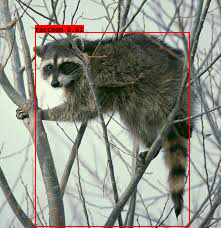

In [10]:
r_image

(416, 416, 3)
Found 1 boxes for img
raccoon 0.31 (72, 0) (180, 194)
0.05897379999998975


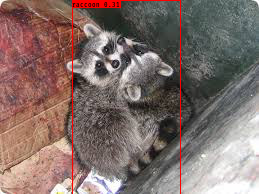

In [11]:
image = Image.open('raccoon-198.jpg')
r_image = model.detect_image(image)
r_image